In [25]:
import os

from collections import OrderedDict
from coffea import nanoevents
from coffea.lookup_tools.dense_lookup import dense_lookup

import numpy as np
import awkward as ak
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import hist
import mplhep as hep

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 14})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"
plt.rcParams["figure.dpi"] = 100

In [1]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = "../../../"

plot_dir = f"{MAIN_DIR}/plots/TTCheck/24Mar27"

_ = os.system(f"mkdir -p {plot_dir}")

In [5]:
run2_sig_path = "/eos/uscms/store/user/lpcpfnano/cmantill/v2_3/2018/TTbar/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic/220808_151154/0000/nano_mc2018_3-261.root"
run3_sig_path = "root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/Run3Summer22EENanoAODv12/TTto4Q_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v2/2520000/0bea9b42-47ee-41fd-b976-31079fd198a6.root"

In [10]:
events_dict = OrderedDict()
events_dict["run2"] = nanoevents.NanoEventsFactory.from_root(
    run2_sig_path, schemaclass=nanoevents.NanoAODSchema
).events()
events_dict["run3"] = nanoevents.NanoEventsFactory.from_root(
    run3_sig_path, schemaclass=nanoevents.NanoAODSchema
).events()

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1937 branches) at 0x7fa4b1f71700>, taking first instance
  warnings.warn(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1937 branches) at 0x7fa4b1f71700>, taking first instance
  warnings.warn(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1937 branches) at 0x7fa4b1f71700>, taking first instance
  warnings.warn(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch

In [13]:
HLTs = ["AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35", "AK8PFJet425_SoftDropMass40"]

events = events_dict["run3"]

HLT_triggered = np.any(
    np.array([events.HLT[trigger] for trigger in HLTs]),
    axis=0,
)

In [20]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float = 0,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret


def trig_effs(fatjets, year: str = "2018", num_jets: int = 2):
    """Add the trigger efficiencies we measured in SingleMuon data"""
    with open(f"../corrections/data/{year}_triggereff_combined.pkl", "rb") as filehandler:
        combined = pickle.load(filehandler)

    # sum over TH4q bins
    effs_txbb = combined["num"][:, sum, :, :] / combined["den"][:, sum, :, :]

    ak8TrigEffsLookup = dense_lookup(
        np.nan_to_num(effs_txbb.view(flow=False), 0), np.squeeze(effs_txbb.axes.edges)
    )

    # TODO: confirm that these should be corrected pt, msd values
    fj_trigeffs = ak8TrigEffsLookup(
        pad_val(fatjets.Txbb, num_jets, 0, axis=1),
        pad_val(fatjets.pt, num_jets, 0, axis=1),
        pad_val(fatjets.msoftdrop, num_jets, 0, axis=1),
    )

    # combined eff = 1 - (1 - fj1_eff) * (1 - fj2_eff)
    combined_trigEffs = 1 - np.prod(1 - fj_trigeffs, axis=1)
    return combined_trigEffs

In [23]:
fatjets = events_dict["run2"].FatJet
fatjets.Txbb = fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb)
trigeffs = trig_effs(fatjets)

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


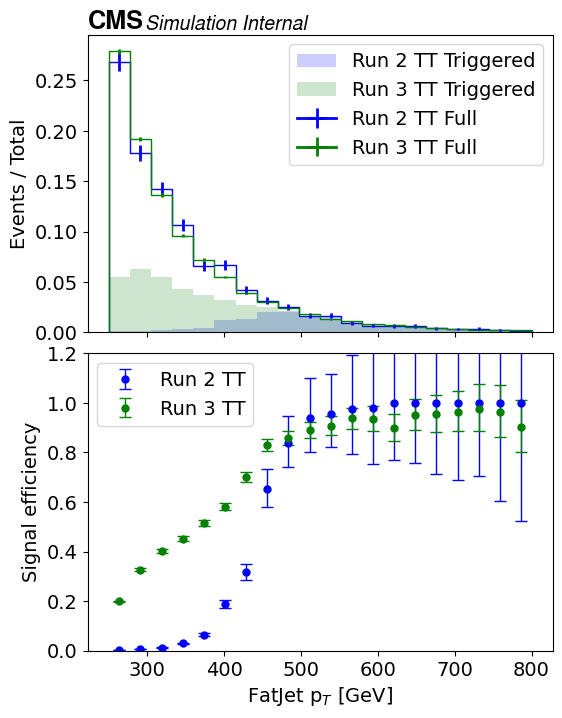

In [32]:
key_label_map = {
    "run2": "Run 2 TT",
    "run3": "Run 3 TT",
}
colors = {"run2": "blue", "run3": "green"}

hists = {}

fig, (ax, rax) = plt.subplots(
    2,
    1,
    figsize=(6, 8),
    gridspec_kw=dict(height_ratios=[1, 1], hspace=0.07),
    sharex=True,
)

for key in ["run2", "run3"]:
    events = events_dict[key]
    run_label = key_label_map[key]
    pt = pad_val(ak.firsts(events.FatJet[:, 0:1].pt), len(events.genWeight))

    hf = hist.Hist.new.Reg(20, 250, 800, name="pt", label=r"FatJet p$_T$ [GeV]").Weight()
    hf.fill(pt, weight=events.genWeight)
    tot = np.sum(hf.values())

    hep.histplot(
        hf / tot,
        yerr=True,
        label=f"{run_label} Full",
        color=colors[key],
        ax=ax,
        flow="none",
    )

    ht = hist.Hist.new.Reg(20, 250, 800, name="pt", label=r"FatJet p$_T$ [GeV]").Weight()
    if key == "run3":
        ht.fill(pt[HLT_triggered], weight=events.genWeight[HLT_triggered])
    else:
        ht.fill(pt, weight=events.genWeight * trigeffs)

    hep.histplot(
        ht / tot,
        yerr=True,
        label=f"{run_label} Triggered",
        histtype="fill",
        alpha=0.2,
        facecolor=colors[key],
        color=colors[key],
        ax=ax,
        flow="none",
    )

    num = ht
    den = hf.values()
    num_values = ht.values()
    hep.histplot(
        num / den,
        # yerr=abs(clopper_pearson_interval(num_values, den) - num_values / den),
        yerr=True,
        ax=rax,
        histtype="errorbar",
        capsize=4,
        color=colors[key],
        label=run_label,
        flow="none",
    )

    hists[key] = {"full": hf, "triggered": ht}

ax.set_xlabel(None)
ax.set_ylabel("Events / Total")
ax.legend(fancybox=True)

# rax.hlines(1, bins[1], bins[2], color="lightgray", linestyles="--")
rax.set_ylabel("Signal efficiency")
rax.set_ylim([0, 1.2])
rax.legend()

hep.cms.text(
    "Simulation Internal",
    ax=ax,
)

plt.savefig(f"{plot_dir}/signal_trigger_effs_pt.pdf", bbox_inches="tight")
plt.show()